In [1]:
from IPython.display import FileLink

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau


from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Concatenate

import os
import imageio.v2 as imageio  

In [3]:
#initial parameters
n = 1000
RV = np.arange(-18000,18001,500)

In [4]:
data_matrices = {}
for i in range(n):
    filename = f'STARSIM_output_CCFr_{i}.txt'
    data_matrix = np.loadtxt(filename)
    data_matrices[f'd{i}'] = data_matrix

In [5]:
for i in range(n):
    data_matrices[f'd{i}'] = data_matrices[f'd{i}'][:,1:]

In [6]:
for i in range(n):
    data_matrices[f'd{i}'] = data_matrices[f'd{i}'].T
for i in range(n):
    data_matrices[f'd{i}'] = np.reshape(data_matrices[f'd{i}'],27*73)

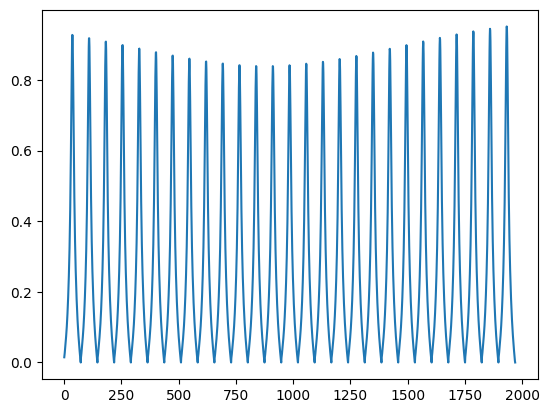

In [32]:
plt.plot(np.arange(0,73*27,1), data_matrices['d10'])

In [7]:
n_train = int(n*0.9*0.9)
n_val = int(n*0.9*0.1)
n_test = n-n_train-n_val

train_data = []
val_data = []
test_data = []

In [8]:
for i in range(n_train):
    train_data.append(data_matrices[f'd{i}'])

for i in range(n_train,n_train+n_val,1):
    val_data.append(data_matrices[f'd{i}'])
    
for i in range(n_train+n_val,n,1):
    test_data.append(data_matrices[f'd{i}'])

In [35]:
np.shape(test_data)

(6, 1971)

In [9]:
train_data = np.array(train_data).reshape(n_train,27*73)
val_data = np.array(val_data).reshape(n_val,27*73)
test_data = np.array(test_data).reshape(n_test, 27*73)

In [37]:
train2 = train_data[0,:].reshape(27,73)

image_filenames = []

jet=plt.get_cmap('rainbow')
colors = iter(jet(np.linspace(0,1,27)))

for j in range(27):
  plt.plot(RV[:], train2[j,:], color=next(colors))  
  plt.xlabel('RV')
  plt.ylabel('diff CCF')
  plt.title(f'Time Step {j}')
  filename = f'plot_{j}.png'
  plt.savefig(filename)
  plt.close() 
  image_filenames.append(filename)
with imageio.get_writer('prova_train.gif', mode='I') as writer:
    for filename in image_filenames:
        image = imageio.imread(filename)
        for _ in range(int(2)):
            writer.append_data(image)
for filename in image_filenames:
   os.remove(filename)

FileLink('prova_train.gif')

C:\Users\jenni\starsim\new_data_1period\1CCF\prova_train.gif

In [34]:
latent_dim = 1
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
        layers.Dense(27*73, activation='linear'),
        layers.Dense(1500, activation='relu'),
          layers.Dense(500, activation='linear'),
          layers.Dense(500, activation='relu'),
          layers.Dense(latent_dim, activation='relu'),
          ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(500, activation='relu'),
            layers.Dense(500, activation='linear'),
            layers.Dense(1500, activation='relu'),
            layers.Dense(27*73, activation='linear'),
          ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


autoencoder = Autoencoder(latent_dim=latent_dim)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-8)

initial_learning_rate = 0.1
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
              loss='mse')

optimizer = tf.keras.optimizers.Adam()


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


history = autoencoder.fit(train_data, train_data,
                          epochs=50,
                          shuffle=True,
                          batch_size=64,
                          validation_data=(val_data, val_data),
                           callbacks=[reduce_lr, early_stopping])



Epoch 1/50
13/13 [==============================] - 4s 133ms/step - loss: 0.0391 - val_loss: 0.0114 - lr: 0.1000
Epoch 2/50
13/13 [==============================] - 1s 87ms/step - loss: 0.0082 - val_loss: 0.0020 - lr: 0.1000
Epoch 3/50
13/13 [==============================] - 1s 90ms/step - loss: 0.0018 - val_loss: 0.0011 - lr: 0.1000
Epoch 4/50
13/13 [==============================] - 1s 89ms/step - loss: 6.0354e-04 - val_loss: 4.0817e-04 - lr: 0.1000
Epoch 5/50
13/13 [==============================] - 1s 89ms/step - loss: 3.0032e-04 - val_loss: 2.0879e-04 - lr: 0.1000
Epoch 6/50
13/13 [==============================] - 1s 89ms/step - loss: 2.0104e-04 - val_loss: 1.5366e-04 - lr: 0.1000
Epoch 7/50
13/13 [==============================] - 1s 86ms/step - loss: 1.7310e-04 - val_loss: 1.4560e-04 - lr: 0.1000
Epoch 8/50
13/13 [==============================] - 1s 83ms/step - loss: 1.6622e-04 - val_loss: 1.4289e-04 - lr: 0.1000
Epoch 9/50
13/13 [==============================] - 1s 82ms/ste

In [11]:
test_pred = np.reshape(test_data[0,:], (1,27*73))
predictions = autoencoder.predict(test_pred)
predictions = np.reshape(predictions, (27*73))

1/1 [==============================] - 0s 327ms/step


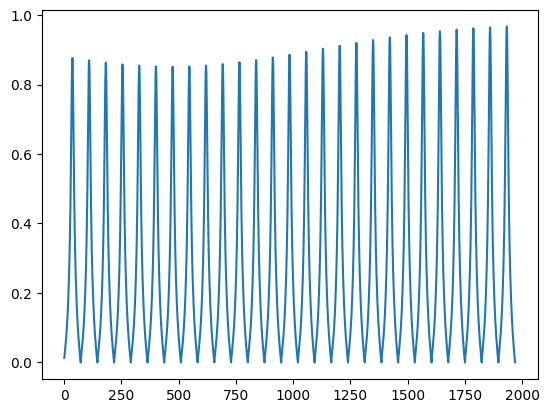

In [73]:
plt.plot(np.arange(0,73*27,1), predictions)

In [13]:
predictions = np.reshape(predictions, (27,73))

In [16]:
jet=plt.get_cmap('rainbow')
colors=iter(jet(np.linspace(0,0.5,27)))
colors1=iter(jet(np.linspace(0.5,1,27)))
test2 = test_data[0,:].reshape(27,73)


image_filenames2 = []
for j in range(27):
  plt.plot(RV[:], predictions[j,:], color=next(colors))  
  plt.plot(RV[:], test2[j,:], color='red')  
  plt.xlabel('RV')
  plt.ylim((0,1))
  plt.ylabel('CCF')
  plt.title(f'Time Step {j}')
  filename = f'plot_{j}.png'
  plt.savefig(filename)
  plt.close() 
  image_filenames2.append(filename)
with imageio.get_writer('plotsTest2_pred_proba.gif', mode='I') as writer:
  for filename in image_filenames2:
    image = imageio.imread(filename)
    writer.append_data(image)

for filename in image_filenames2:
   os.remove(filename)

FileLink('plotsTest2_pred_proba.gif')


C:\Users\jenni\starsim\new_data_1period\1CCF\plotsTest2_pred_proba.gif

# LATENT SPACE

In [38]:
test_pred = np.reshape(test_data[0,:], (1,27*73))
latent_radius = autoencoder.encoder(test_pred)

In [39]:
latent_radius

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>